- Reference
  - https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py

In [1]:
import os

In [2]:
os.makedirs('data/images', exist_ok=True)
os.makedirs('data/saved_models', exist_ok=True)

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from tensorflow.keras.layers import BatchNormalization, Embedding
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [21]:
class CGAN():
    def __init__(self):
        self.history = pd.DataFrame({}, columns=['d_loss', 'acc', 'g_loss'])

        self.img_save_dir = 'data/images'
        self.model_save_dir = 'data/saved_models'
        self.combined_name = 'combined_model'

        # Input shape, NHWC
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        self.d_inner_model = None
        self.discriminator = None
        self.g_inner_model = None
        self.generator = None
        self.combined = None

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        #model.summary()
        self.g_inner_model = model

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])

        img = self.g_inner_model(model_input)

        model2 = Model([noise, label], img)

        return model2

    def build_discriminator(self):
        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))

        #model.summary()
        self.d_inner_model = model

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = self.d_inner_model(model_input)

        model2 = Model([img, label], validity)

        return model2

    def train(self, epochs, batch_size=128, sample_interval=50):
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            #print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            self.history = self.history.append({'d_loss': d_loss[0], 'acc': d_loss[1], 'g_loss': g_loss}, ignore_index=True)

            # If at save interval => save generated image samples
            if sample_interval > 0 and epoch % sample_interval == 0:
                print(datetime.datetime.now().isoformat(), '%d [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

    def generate_image(self, label=0):
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        labels = np.array([[label]])
        return self.generator.predict([noise, labels])

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i, j].axis('off')
                cnt += 1

        file_path = os.path.join(self.img_save_dir, '%d.png' % epoch)
        fig.savefig(file_path)

        plt.close()

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['d_loss', 'acc', 'g_loss']
        self.history[columns].plot()

    def save_models(self):
        self.save_model_weights(self.combined, self.combined_name)

    def save_model_weights(self, model, model_name):
        file_path = os.path.join(self.model_save_dir, '{}.h5'.format(model_name))
        model.save_weights(file_path)

        print('Model weights saved.', model_name)

    def load_models(self):
        self.load_model_weights(self.combined_name)

    def load_model_weights(self, model_name):
        model = None

        if model_name == self.combined_name:
            model = self.combined
        else:
            print('Unsupported.', model_name)
            return

        if not model:
            print('Not initialized.', model_name)
            return

        file_path = os.path.join(self.model_save_dir, '{}.h5'.format(model_name))

        if not os.path.exists(file_path):
            print('File Not found.', model_name)
            return

        model.load_weights(file_path)

        print('Model weights loaded.', model_name)       

In [6]:
cgan = CGAN()

In [7]:
cgan.train(epochs=1000, batch_size=32, sample_interval=100)

2020-07-22T21:58:51.489098 0 [D loss: 0.695694, acc.: 23.44%] [G loss: 0.679058]
2020-07-22T21:58:57.355974 100 [D loss: 0.098783, acc.: 95.31%] [G loss: 6.612108]
2020-07-22T21:59:03.193914 200 [D loss: 0.208766, acc.: 90.62%] [G loss: 4.887123]
2020-07-22T21:59:09.108980 300 [D loss: 0.429186, acc.: 76.56%] [G loss: 3.082256]
2020-07-22T21:59:14.960012 400 [D loss: 0.311179, acc.: 90.62%] [G loss: 2.747677]
2020-07-22T21:59:20.908466 500 [D loss: 0.582817, acc.: 64.06%] [G loss: 1.984607]
2020-07-22T21:59:26.740314 600 [D loss: 0.409400, acc.: 79.69%] [G loss: 1.631233]
2020-07-22T21:59:32.539324 700 [D loss: 0.482867, acc.: 70.31%] [G loss: 1.721485]
2020-07-22T21:59:38.368974 800 [D loss: 0.586607, acc.: 70.31%] [G loss: 1.410434]
2020-07-22T21:59:44.430209 900 [D loss: 0.510702, acc.: 68.75%] [G loss: 1.189568]


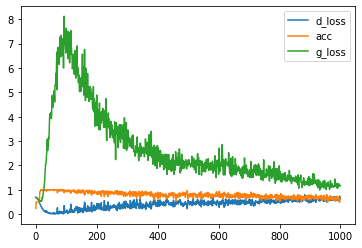

In [8]:
cgan.plot_hisotry()

In [9]:
cgan.save_models()

Model weights saved. combined_model


### 保存した combinedモデルの weights から復元して推論を実行

In [22]:
cgan2 = CGAN()
cgan2.load_models()

Model weights loaded. combined_model


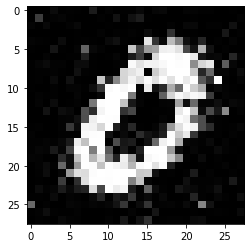

In [23]:
plt.imshow((cgan2.generate_image())[0], cmap='gray')

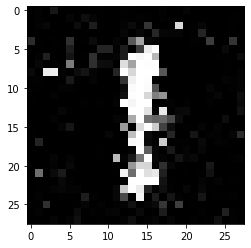

In [24]:
plt.imshow((cgan2.generate_image(label=1))[0], cmap='gray')